# MNIST (TensorFlow)

[![Open in Colab](https://lab.aef.me/files/assets/colab-badge.svg)](https://colab.research.google.com/github/adamelliotfields/lab/blob/main/files/tf/mnist.ipynb)
[![Open in Kaggle](https://lab.aef.me/files/assets/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/adamelliotfields/lab/blob/main/files/tf/mnist.ipynb)
[![Render nbviewer](https://lab.aef.me/files/assets/nbviewer_badge.svg)](https://nbviewer.org/github/adamelliotfields/lab/blob/main/files/tf/mnist.ipynb)

[MNIST](http://yann.lecun.com/exdb/mnist/) classifier using the [LeNet-5](http://yann.lecun.com/exdb/lenet/) architecture. See [IEEE Signal Processing](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/MNIST-SPM2012.pdf). Explore the dataset on [Know Your Data](https://knowyourdata-tfds.withgoogle.com/#dataset=mnist).

In [1]:
%matplotlib inline

import io
import os
import pickle
import sys

import ipywidgets as widgets
import tensorflow as tf

from IPython.display import display, HTML
from PIL import Image

os.environ["KERAS_BACKEND"] = "tensorflow"

from keras import models

In [2]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# https://github.com/adamelliotfields/lab/tree/main/files/lib/
from lib import load_keras_dataset, plot_keras_history, show_dataset_images

# https://github.com/adamelliotfields/lab/tree/main/files/models/
from models import get_lenet

In [3]:
# @title Config
VERBOSE = 0
EPOCHS = 10
BATCH_SIZE = 200
TEST_SIZE = 10000
TRAIN_SIZE = 57000
VALIDATION_SIZE = 3000
MODEL_PATH = "lenet-mnist.keras"
HISTORY_PATH = "lenet-mnist-history.pkl"

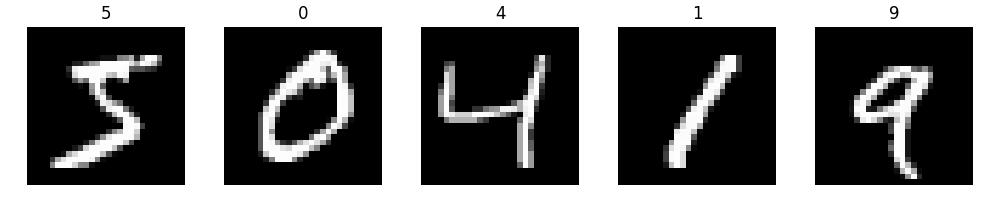

In [4]:
# @title Data
def prepare_data(X, y):
    image = tf.expand_dims(X, -1)
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.one_hot(y, 10)
    return image, label


mnist_train, mnist_test = load_keras_dataset("mnist", map_func=prepare_data, batch_size=BATCH_SIZE)
mnist_validation = mnist_train.skip(TRAIN_SIZE // BATCH_SIZE).take(VALIDATION_SIZE // BATCH_SIZE)
show_dataset_images(mnist_train, unbatch=True)

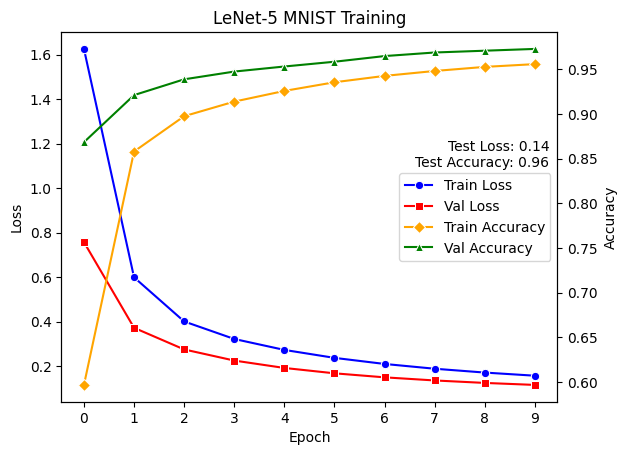

In [5]:
# @title Model
if os.path.exists(MODEL_PATH) and os.path.exists(HISTORY_PATH):
    model = models.load_model(MODEL_PATH)
    with open(HISTORY_PATH, "rb") as f:
        history = pickle.load(f)
else:
    model = get_lenet()
    history = model.fit(
        mnist_train.take(TRAIN_SIZE // BATCH_SIZE),
        epochs=EPOCHS,
        verbose=VERBOSE,
        validation_data=mnist_validation,
    )
    model.save(MODEL_PATH)
    with open(HISTORY_PATH, "wb") as f:
        pickle.dump(history, f)

metrics = model.evaluate(mnist_test.take(TEST_SIZE // BATCH_SIZE), verbose=VERBOSE)

plot_keras_history(
    history,
    markers=True,
    metrics=metrics,
    x_ticks=range(EPOCHS),
    title="LeNet-5 MNIST Training",
)

## Demo

Select a class from 0-9 using the combobox and then select an image from the list to preview it. Press the "Predict" button to see the model's classification. These are samples **not** seen during training.

In [ ]:
# @title App with ipywidgets
X_test_slice, y_test_slice = [], []
for image, label in mnist_test.unbatch().take(100):
    X_test_slice.append(tf.squeeze(image).numpy())
    y_test_slice.append(tf.argmax(label).numpy())

# styling is a little off in colab
class_combobox = widgets.Combobox(
    options=[str(i) for i in range(10)],
    layout={"width": "280px"},
    ensure_option=False,
    value="",
)

index_select = widgets.Select(
    layout={"width": "280px", "height": "108px"},
    disabled=True,
    value=None,
    options=[],
)

image_widget = widgets.Image(
    layout={"height": "140px", "width": "140px", "border": "1px solid lightgray"},
    format="png",
)

predict_button = widgets.Button(
    layout={"width": "280px"},
    button_style="success",
    description="Predict",
)

output_widget = widgets.Output(
    layout={"height": "140px", "width": "140px", "border": "1px solid lightgray"}
)


def update_class(change):
    selected_class = change["new"]

    if selected_class != "":
        selected_class = int(selected_class)
        indices = [i for i, label in enumerate(y_test_slice) if label == selected_class]
        index_select.options = indices
        index_select.value = indices[0]
        index_select.disabled = False
    else:
        indices = []
        index_select.value = None
        index_select.options = []
        index_select.disabled = True

    output_widget.clear_output()


def get_image(index):
    if index is None:
        # 1x1 transparent png
        img = Image.new("RGBA", (1, 1), (0, 0, 0, 0))
    else:
        img = Image.fromarray(X_test_slice[index] * 255)
        if img.mode == "F":
            img = img.convert("L")  # convert to grayscale

    buf = io.BytesIO()
    img.save(buf, format="PNG")

    return buf.getvalue()


def update_image(change):
    selected_index = change["new"]

    if index_select.value is not None and selected_index != "":
        selected_index = int(selected_index)
        image_widget.value = get_image(selected_index)
    else:
        image_widget.value = get_image(None)

    output_widget.clear_output()


def predict(_):
    global model
    selected_index = index_select.value

    if selected_index is not None:
        x = X_test_slice[index_select.value]
        x = tf.expand_dims(x, -1)
        x = tf.image.convert_image_dtype(x, tf.float32)
        x = x[tf.newaxis, ...]
        y_preds = model.predict(x, verbose=0)
        y_preds = tf.argmax(y_preds, axis=-1).numpy()
        with output_widget:
            output_widget.clear_output()
            display(
                HTML(
                    f'<h1 style="font-family: monospace; font-size: 56px; text-align: center;">{y_preds[0]}</h1>'
                )
            )


image_widget.value = get_image(None)

class_combobox.observe(update_class, names="value")
index_select.observe(update_image, names="value")
predict_button.on_click(predict)

vbox1 = widgets.VBox([class_combobox, index_select, predict_button])
vbox2 = widgets.VBox([image_widget], layout={"overflow": "hidden"})
vbox3 = widgets.VBox([output_widget])

widgets.HBox([vbox1, vbox2, vbox3])